In [1161]:
import warnings
warnings.filterwarnings("ignore")

import pytrends 
from pytrends.request import TrendReq

import pandas as pd
import plotly.express as px

from statsmodels.stats.proportion import proportions_ztest

from datetime import timedelta, datetime
from scipy.signal import find_peaks
import numpy as np

import matplotlib.pyplot as plt


### Functions

In [1162]:
def get_google_trends(start_year, end_year, drug):

    pytrends = TrendReq() 
    pytrends.build_payload([drug], cat=0, timeframe=f'{start_year}-01-18 {end_year}-01-18', geo='NL') 

    data = pytrends.interest_over_time() #.drop('isPartial', axis=1)
        
    data['date']=data.index
    data['week'] = data.date.apply(lambda x: x.strftime('%U')).astype(int)
    data['year'] = data.date.apply(lambda x: x.strftime('%Y')) 
    data['week_end'] = data['date'] + pd.DateOffset(days=6)
    
    return data

In [1163]:
def read_data_from_csv(drug):
    data=pd.read_csv(f'{drug}_2023.csv')
    
    data.columns=[drug]
    data=data.iloc[1: , :]

    data[drug] = data[drug].astype(int)
    data['date'] = pd.to_datetime(data.index).date
    data['week'] = data.date.apply(lambda x: x.strftime('%U')).astype(int)
    data['year'] = data.date.apply(lambda x: x.strftime('%Y')) 
    data['week_end'] = data['date'] + pd.DateOffset(days=6)
    data['week_start']=pd.to_datetime(data.date)
    data['date'] = data.date.apply(lambda x: x.strftime("%Y-%m-%d"))
    
    return data

In [1164]:
def get_kingsday_date(year):
    return pd.to_datetime(f"27-04-{year}")

def get_nye_date(year):
    return pd.to_datetime(f"31-12-{year}")

def get_ADE_date(year):
    dates = pd.read_csv('ADE.csv', ',', index_col=0)
    date = dates.at[int(year), 'date']
    return pd.to_datetime(f"{date}-{year}")

def get_lowlands_date(year):
    dates = pd.read_csv('Lowlands.csv', ',', index_col=0)
    date = dates.at[int(year), 'date']
    return pd.to_datetime(f"{date}-{year}")

def get_pride_date(year):
    dates = pd.read_csv('Pride.csv', ',', index_col=0)
    date = dates.at[int(year), 'date']
    return pd.to_datetime(f"{date}-{year}")

In [1165]:
def test_hypothesis(sample_size, null_hypothesis, event, significance=0.05):
    sample_success = data[f'{event}_peak'].sum()
    stat, p_value = proportions_ztest(count=sample_success, nobs=sample_size, value=null_hypothesis, alternative='larger')
    
    if p_value > significance:
        outcome='FAIL to reject H0'
    else:
        outcome='REJECT H0'
    return stat, p_value, outcome

In [1166]:
def test_event(event, results, sample_size, null_hypothesis):
    results[event]={}

    results[event]['stat'], results[event]['p_value'],  results[event]['outcome'] = \
    test_hypothesis(sample_size, null_hypothesis,event)
    
    return results

In [1167]:
def get_google_trends_per_year(year, drug):

    pytrends = TrendReq() 
    pytrends.build_payload([drug], cat=0, timeframe=f'{year}-01-01 {year}-12-31', geo='NL') 

    data = pytrends.interest_over_time() #.drop('isPartial', axis=1)
        
    data['date']=data.index
    data['week'] = data.date.apply(lambda x: x.strftime('%U')).astype(int)
    data['year'] = data.date.apply(lambda x: x.strftime('%Y')) 
    data['week_end'] = data['date'] + pd.DateOffset(days=6)
    
    return data

### Define search

In [1168]:
drug = 'GHB+ghb'

### Load data

In [1174]:
data1 = get_google_trends(2014, 2018, drug)
data2 = get_google_trends(2018, 2023, drug)
data=pd.concat([data1, data2])

# Make relative data per year
#data_per_year = pd.DataFrame()
#for year in range(2018, 2023):
    #data_year = get_google_trends_per_year(year, drug)
    #data_year = data_year[["year", "week", drug]].set_index(['year'])
    #data_year = data_year.rename(columns = {drug:'score'})
    #data_per_year = data_per_year.append(data_year)
#data_per_year
#data_year.to_csv(f'{drug}_per_year.csv')
#data_year = data_year.set_index('week')
#plt.plot(data_year['score'])
#data.week.max()

### Get peaks

In [1177]:
peaks, _ = list(find_peaks(data[drug]))

peak_values = data[drug][peaks]
peak_weeks = data[drug][peaks].index

data['is_peak'] = data.date.apply(lambda x: True if x in peak_weeks else False)

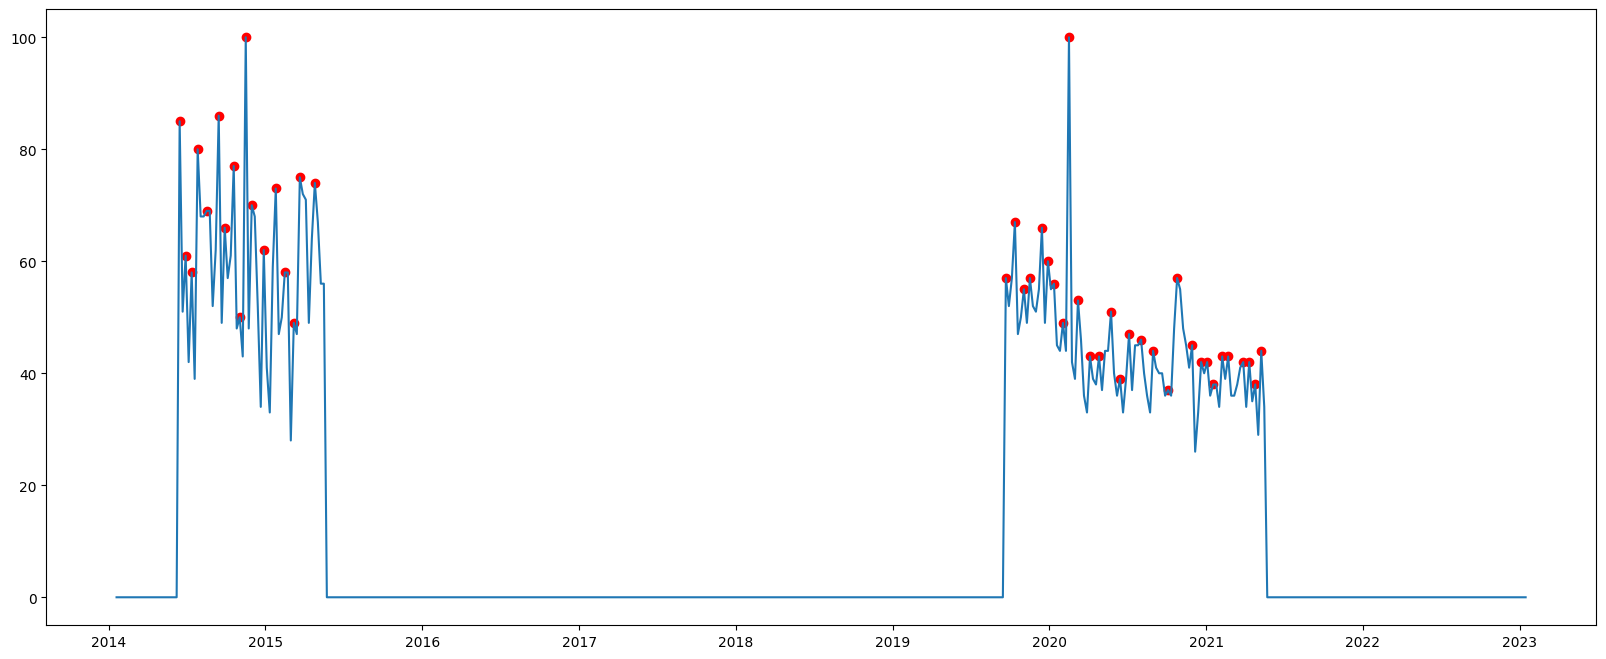

In [1178]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(8)

#plot each series
plt.plot(data[drug])
plt.scatter(peak_weeks, peak_values, color='r')



#display plot
plt.show()

### King's day

In [1032]:
data['Kings_day'] = data.year.apply(get_kingsday_date)
data['is_kingsday_week'] = ((data['Kings_day']>=data.date) & (data['Kings_day']<=data.week_end))

data['Kingsday_peak'] = ((data.is_kingsday_week==True) & (data.is_peak==True))

### NYE

In [1033]:
data['NYE'] = data.year.apply(get_nye_date)
data['is_NYE_week'] = ((data['NYE']>=data.date) & (data['NYE']<=data.week_end))

data['NYE_peak'] = ((data.is_NYE_week==True) & (data.is_peak==True))

### ADE

In [1034]:
data['ADE'] = data.year.apply(get_ADE_date)
data['is_ADE_week'] = ((data['ADE']>=data.date) & (data['ADE']<=data.week_end))

data['ADE_peak'] = ((data.is_ADE_week==True) & (data.is_peak==True))

### Lowlands

In [1035]:
data['Lowlands'] = data.year.apply(get_lowlands_date)
data['is_Lowlands_week'] = ((data['Lowlands']>=data.date) & (data['Lowlands']<=data.week_end))

data['Lowlands_peak'] = ((data.is_Lowlands_week==True) & (data.is_peak==True))

### Gay Pride Amsterdam

In [1036]:
data['Pride'] = data.year.apply(get_pride_date)
data['is_Pride_week'] = ((data['Pride']>=data.date) & (data['Pride']<=data.week_end))

data['Pride_peak'] = ((data.is_Pride_week==True) & (data.is_peak==True))

### Each week 

In [1037]:
for week_num in range(1,53):
    data[f'week_{week_num}_peak'] = False
    for index, row in data.iterrows():
        if ((data.loc[index].is_peak==True) & (data.loc[index].week==week_num)):
            data.at[index, f'week_{week_num}_peak']=True

### CHECK and OUTPUT

In [1038]:
print(drug)
data.to_csv(f'{drug}.csv')

GHB+ghb


---

### Proportion test of week proportions

- H0:	No difference between average of peaks for week X and the average of the other weeks  
- H1:	There is difference

In [1039]:
# sample size
year_count = data.year.nunique()-1

# proportion
prop = {}
for week_num in range(1,53):
    prop[f'Week {week_num}'] = data[f'week_{week_num}_peak'].sum()/year_count
    
weekly_prop = pd.DataFrame(data=prop.values(), index=prop.keys(), columns=['prop'])

# porportion 0
p_0 = weekly_prop.prop.mean()

In [1040]:
results={}
events = ['Kingsday', 'NYE', 'ADE', 'Lowlands', 'Pride']

for event in events:
    results = test_event(event=event, 
               results=results, 
               sample_size=year_count, 
               null_hypothesis=p_0)

test_results = pd.DataFrame(results)
test_results

,Kingsday,NYE,ADE,Lowlands,Pride
stat,2.284499,0.825625,1.496445,-1.876553,1.496445
p_value,0.011171,0.204508,0.067269,0.96971,0.067269
outcome,REJECT H0,FAIL to reject H0,FAIL to reject H0,FAIL to reject H0,FAIL to reject H0


In [1041]:
test_results.to_csv(f'{drug}_test_results.csv')